In [1]:
#libs

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import time
import sklearn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as m
import matplotlib.pyplot as plt

%matplotlib inline

# *Load*

In [2]:
# load and put columns name in english

df = pd.read_csv('data/dataset.csv', encoding='utf-8').rename(columns={'id_transacao':'id', 
                                                                        'horario_pedido':'date',
                                                                        'localidade':'locality', 
                                                                        'nome_item':'plate',
                                                                        'quantidade_item':'qty'})
df.drop(['latitude','longitude'], axis=1, inplace=True)
df.head()

,id,date,locality,plate,qty
0,0x7901ee,2019-01-16 18:33:00,7,bebida,2
1,0x7901ee,2019-01-16 18:33:00,7,pizza,2
2,0x7901ee,2019-01-16 18:33:00,7,sobremesa,2
3,0x12b47f,2019-09-04 12:36:00,3,salada,1
4,0x12b47f,2019-09-04 12:36:00,3,sobremesa,1


# *Data Munging*

In [3]:
print(f'Number of row: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of row: 260645
Number of columns: 5


In [4]:
# columns information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260645 entries, 0 to 260644
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        260645 non-null  object
 1   date      260645 non-null  object
 2   locality  260645 non-null  int64 
 3   plate     260645 non-null  object
 4   qty       260645 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 9.9+ MB


In [5]:
# locality's and qty's describe
df.describe()

,locality,qty
count,260645.000000,260645.000000
mean,5.134904,2.447010
std,2.551846,1.330863
min,1.000000,1.000000
25%,3.000000,1.000000
50%,5.000000,2.000000
75%,7.000000,4.000000
max,9.000000,5.000000


In [6]:
# put plate name in english
df['plate'].replace({'bebida':'drink', 'sobremesa':'desert', 'salada':'salad'}, inplace=True)

In [7]:
# date granularity
df['date'] = pd.to_datetime(df['date'])
df['year'] = [x.year for x in df['date']]
df['month'] = [x.month for x in df['date']]
df['day'] = [x.day for x in df['date']]
df['weekday'] = [x.weekday() for x in df['date']] # 0-6 -> Mon-Sun
df['weekend'] = [True if x in [0,6] else False for x in df['weekday']]
df.head(3)

,id,date,locality,plate,qty,year,month,day,weekday,weekend
0,0x7901ee,2019-01-16 18:33:00,7,drink,2,2019,1,16,2,False
1,0x7901ee,2019-01-16 18:33:00,7,pizza,2,2019,1,16,2,False
2,0x7901ee,2019-01-16 18:33:00,7,desert,2,2019,1,16,2,False


In [8]:
# Number of unique values
pd.DataFrame({'Columns':df.nunique().index,'Numb of Unique Values':df.nunique().values})

,Columns,Numb of Unique Values
0,id,100000
1,date,76799
2,locality,9
3,plate,4
4,qty,5
5,year,1
6,month,12
7,day,31
8,weekday,7
9,weekend,2


# *Exploratory Data Analysis*

## Table Pivot

Per plate

In [9]:
%%time

# making pivot table without function

order = []

for k, group in df.groupby('id'):
    for m, n in group.groupby('date'):
        
        date = m
        id_order = k
        n = n.reset_index(drop = True)
        drink, pizza, desert, salad = 0, 0, 0, 0
        locality = n['locality'].values.tolist()[0]

        # make the count
        for i in range(len(n)):
            item = n.loc[i, 'plate']
            qty = n.loc[i, 'qty']
            
            if item == 'drink':
                drink += qty
            elif item == 'pizza':
                pizza += qty
            elif item == 'desert':
                desert += qty
            elif item == 'salad':
                salad += qty
        
        output = [id_order, date, locality, drink, pizza, desert, salad]
        order.append(output)
        
df_pivot_plate = pd.DataFrame(order, columns = ['id_order', 'date', 'locality', 'drink', 'pizza', 'desert', 'salad'])

CPU times: user 3min 12s, sys: 663 ms, total: 3min 13s
Wall time: 3min 14s


In [10]:
df_pivot_plate

,id_order,date,locality,drink,pizza,desert,salad
0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0
1,0x100058,2019-05-05 00:08:00,6,0,2,2,0
2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1
3,0x10014c,2019-02-23 00:15:00,6,0,1,1,0
4,0x1001d8,2019-06-30 17:50:00,2,3,3,3,0
...,...,...,...,...,...,...,...
99995,0xffe96,2019-01-05 19:28:00,4,4,4,4,0
99996,0xffeed,2019-08-08 00:42:00,2,0,1,1,0
99997,0xfff07,2019-05-04 00:48:00,2,1,1,1,0
99998,0xfff4d,2019-07-18 00:17:00,3,0,2,2,0


Per Day

In [11]:
%%time

df_pivot_day = df.pivot_table(index = ['id'], columns = ['weekday'], values = 'qty')
df_pivot_day = df_pivot_day.fillna(0).reset_index()
df_pivot_day.rename(columns={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday',
                             4:'Friday', 5:'Saturday', 6:'Sunday'}, inplace=True)

CPU times: user 313 ms, sys: 16.1 ms, total: 329 ms
Wall time: 1.12 s


In [12]:
df_pivot_day

weekday,id,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0x10000a,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0x100058,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0x1000c8,3.5,0.0,0.0,0.0,0.0,0.0,0.0
3,0x10014c,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0x1001d8,0.0,0.0,0.0,0.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...
99995,0xffe96,0.0,0.0,0.0,0.0,0.0,4.0,0.0
99996,0xffeed,0.0,0.0,0.0,1.0,0.0,0.0,0.0
99997,0xfff07,0.0,0.0,0.0,0.0,0.0,1.0,0.0
99998,0xfff4d,0.0,0.0,0.0,2.0,0.0,0.0,0.0


## More Graphics

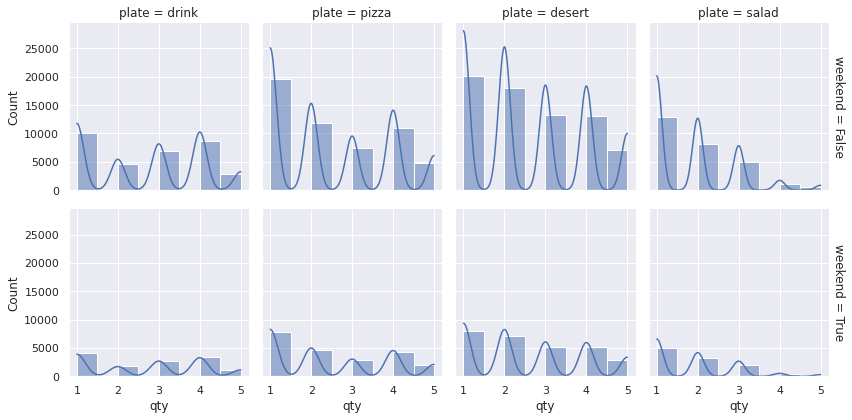

In [13]:
# Number of order per type of plate and if is or not weekend

sns.set_theme(style="darkgrid")
sns.displot(df, x="qty", col="plate", row="weekend", kde=True,
            binwidth=0.5, height=3, facet_kws=dict(margin_titles=True))

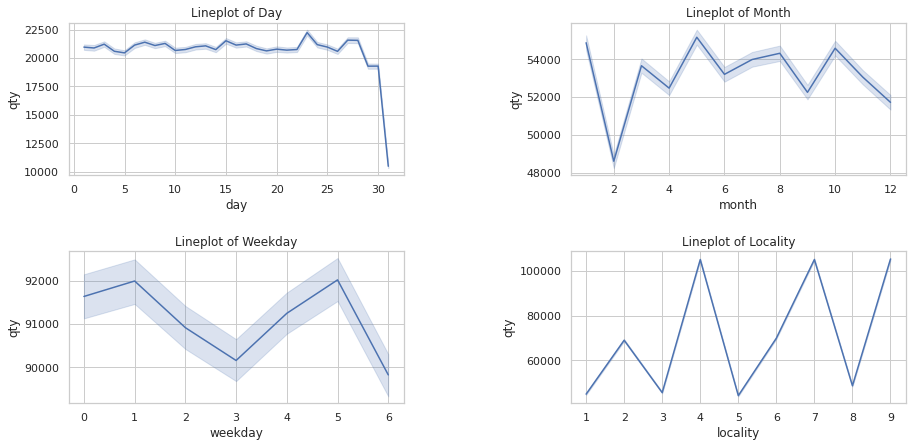

In [14]:
# Linepot of qty per day/month/weekday/locality)

plt.figure(1, figsize=(15,7))
sns.set_theme(style="whitegrid")

n = 0 
for x in ['day' , 'month' , 'weekday', 'locality']:
    n += 1
    plt.subplot(2, 2, n)
    plt.subplots_adjust(hspace=0.5 , wspace=0.5)
    sns.lineplot(data=df, x=x, y="qty",estimator=np.sum)
    plt.title(f'Lineplot of {x.capitalize()}')
plt.show()

<Figure size 1440x720 with 0 Axes>

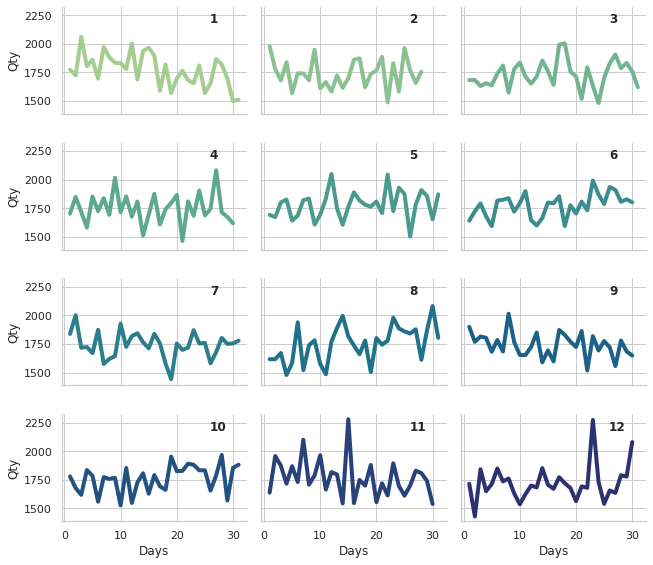

In [15]:
# Quantity of order during 2019

plt.figure(1, figsize = (20 ,10))
sns.set_theme(style="whitegrid")
data = df.groupby(['month','day']).sum()['qty'].reset_index()

g = sns.relplot(
    data=data,
    x="day", y="qty", col="month", hue="month",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,
)
# add title for each graphic
for month, ax in g.axes_dict.items():
    ax.text(.8, .85, month, transform=ax.transAxes, fontweight="bold")

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Days", "Qty")
plt.show()

/home/salomao/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/salomao/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/salomao/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

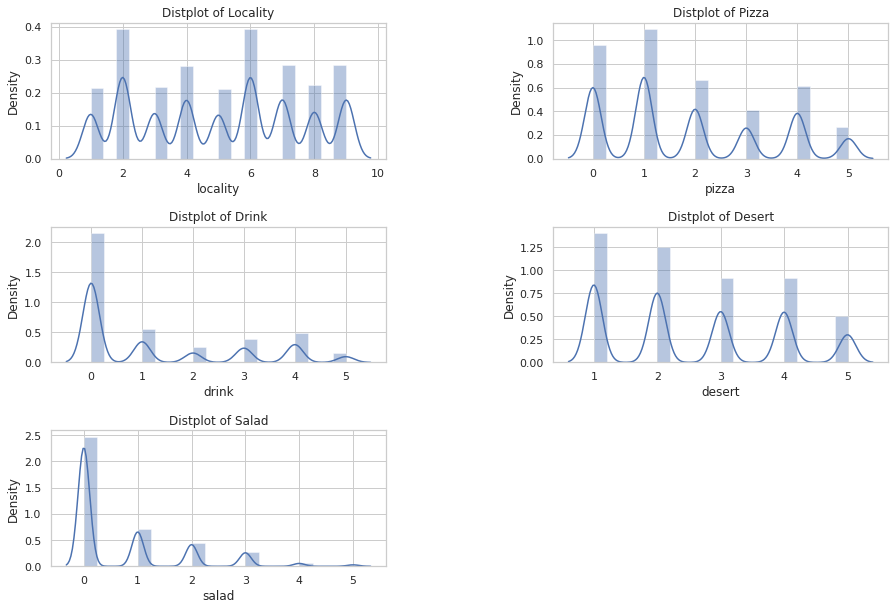

In [16]:
# distplot

sns.set_theme(style="whitegrid")
plt.figure(1, figsize=(15,10))

n = 0 
for x in ['locality', 'pizza', 'drink', 'desert', 'salad']:
    n += 1
    plt.subplot(3, 2, n)
    plt.subplots_adjust(hspace=0.5 , wspace=0.5)
    sns.distplot(df_pivot_plate[x] , bins=20)
    plt.title(f'Distplot of {x.capitalize()}')
plt.show()

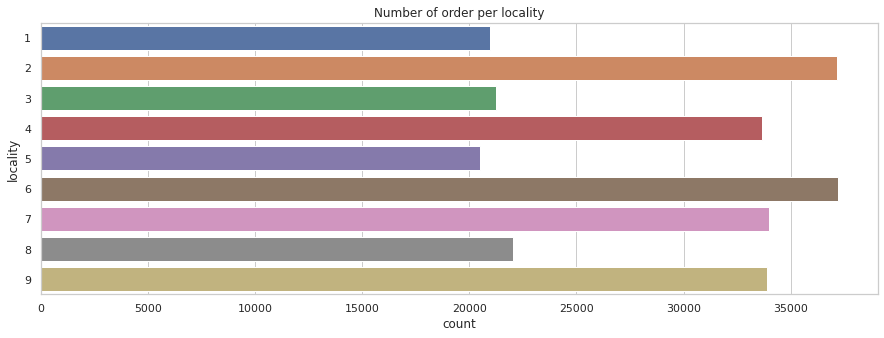

In [17]:
# barplot

sns.set_theme(style="whitegrid")
plt.figure(1, figsize=(15,5))
sns.countplot(y='locality', data=df)
plt.title('Number of order per locality')
plt.show()

# *Machine Learning*

In [18]:
# data split (choosing which features will do the customer segmentantion)

X1 = df_pivot_plate[['pizza', 'desert']].iloc[:,:].values
X1_df = df_pivot_plate[['id_order','pizza', 'desert']].iloc[:,:]
X2 = df_pivot_plate[['pizza', 'desert','drink','salad']].iloc[:,:].values
X2_df = df_pivot_plate[['id_order','pizza', 'desert','drink','salad']].iloc[:,:]

### Elbow Graphic

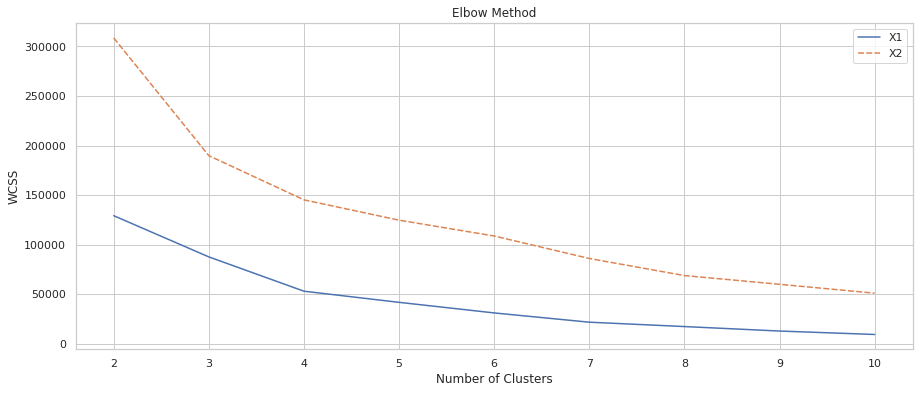

In [19]:
wcss_X1, wcss_X2 = [], []
for n in range(2, 11):
    modeloX1 = KMeans(n_clusters = n, init = 'k-means++', 
                    n_init = 10, max_iter = 300, 
                    tol = 0.0001, random_state = 111, 
                    algorithm = 'elkan')
    modeloX1.fit(X1)
    wcss_X1.append(modeloX1.inertia_)
    
    modeloX2 = KMeans(n_clusters = n, init = 'k-means++', 
                    n_init = 10, max_iter = 300, 
                    tol = 0.0001, random_state = 111, 
                    algorithm = 'elkan')
    modeloX2.fit(X2)
    wcss_X2.append(modeloX2.inertia_)

df_elbow = pd.DataFrame({'X1': wcss_X1, 'X2': wcss_X2},index=np.arange(2 , 11))

# Plot
plt.figure(1 , figsize = (15 ,6))
sns.set_theme(style="whitegrid")
sns.lineplot(data=df_elbow, legend='auto')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.show()

## Segmentation using Pizza and Desert with 2 cluster

### Model Creation

In [ ]:
model_names = ['KMeans', 'AgglomerativeClustering', 'DBSCAN', 'MeanShift']
model_all, labels, centroids, n_cluster = [], [], [], 2
def class_methods(model):
    model.fit(X1)
    labels.append(model.labels_)
    centroids.append(model.cluster_centers_)
    return model
    
model_all.append(class_methods(KMeans(n_clusters=n_cluster, init='k-means++', 
                                      n_init=10, max_iter=300, 
                                      tol=0.0001, random_state=111, 
                                      algorithm = 'elkan')))
model_all.append(class_methods(AgglomerativeClustering(n_clusters=n_cluster)))
model_all.append(class_methods(DBSCAN()))
model_all.append(class_methods(MeanShift(max_iter=300, n_jobs=10)))

### Meshgrid Plot

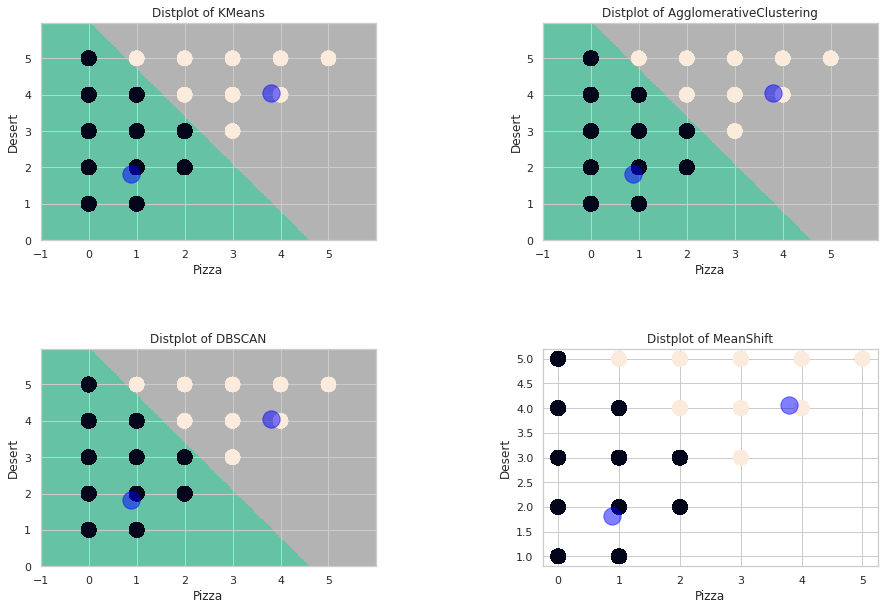

In [23]:
for n in range(1,len(model_all)+1):
    
    # parameters
    h = 0.02
    x_min, x_max = X1[:,0].min()-1, X1[:,0].max()+1
    y_min, y_max = X1[:,1].min()-1, X1[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model_all[n-1].predict(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape)

    # plot
    plt.figure(1, figsize=(15,10))
    sns.set_theme(style="whitegrid")
    plt.imshow(Z, interpolation='nearest', 
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Set2, aspect='auto', origin='lower')

    # plot data
    plt.subplot(2, 2, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.scatter(x='pizza', y='desert', data=df_pivot_plate, c=labels[n-1], s=200 )
    plt.scatter(x=centroids[n-1][:,0], y=centroids[n-1][:,1], s=300, c='blue', alpha=0.5)
    plt.title(f'Distplot of {model_names[n-1]}')
    plt.xlabel('Pizza')
    plt.ylabel('Desert')
    
plt.show()

### Analyzing the Created Segments

In [58]:
m = 0 # 0->KMeans; 1->AgglomerativeClustering; 2->DBSCAN; 3->MeanShift
values_table_all, index_tuples, rows = [], [], []
metrics = ['Mean', 'Summation', 'Median', 'Mode', 'Max', 'Min']
X1_df_tmp = X1_df.copy()
X1_df_tmp['labels'] = labels[m]

for i in X1_df_tmp.labels.unique():
    
    df_tmp = X1_df_tmp[X1_df_tmp['labels'] == i]
    mean, summation = [], []
    median, values_table = [], [i]
    maxi, mini, mode = [], [], []
    
    for p in range(1,3):
        mean.append(np.round(df_tmp.iloc[:,p].mean(),3))
        summation.append(df_tmp.iloc[:,p].sum())
        median.append(np.round(df_tmp.iloc[:,p].median(),3))
        mode.append(df_tmp.iloc[:,p].mode()[0])
        maxi.append(df_tmp.iloc[:,p].max())
        mini.append(df_tmp.iloc[:,p].min())
        values_table.append(df_tmp.iloc[:,p].value_counts())
    for met in range(6):
        index_tuples.append((i,np.round(model_all[m].inertia_,3), metrics[met]))
    rows.append(mean)
    rows.append(summation)
    rows.append(median)
    rows.append(mode)
    rows.append(maxi)
    rows.append(mini)
    values_table_all.append(values_table)

df_final = pd.DataFrame(data=rows, columns=['pizza','desert'], 
                        index=pd.MultiIndex.from_tuples(index_tuples, names=["cluster", "WCSS", "metrics"]))
df_final

pizza      desert
cluster WCSS       metrics                          
0       129145.506 Mean            0.882       1.822
                   Summation   58669.000  121234.000
                   Median          1.000       2.000
                   Mode            1.000       1.000
                   Max             2.000       5.000
                   Min             0.000       1.000
1       129145.506 Mean            3.800       4.056
                   Summation  127115.000  135687.000
                   Median          4.000       4.000
                   Mode            4.000       4.000
                   Max             5.000       5.000
                   Min             1.000       3.000

### Plot number of order in each cluster

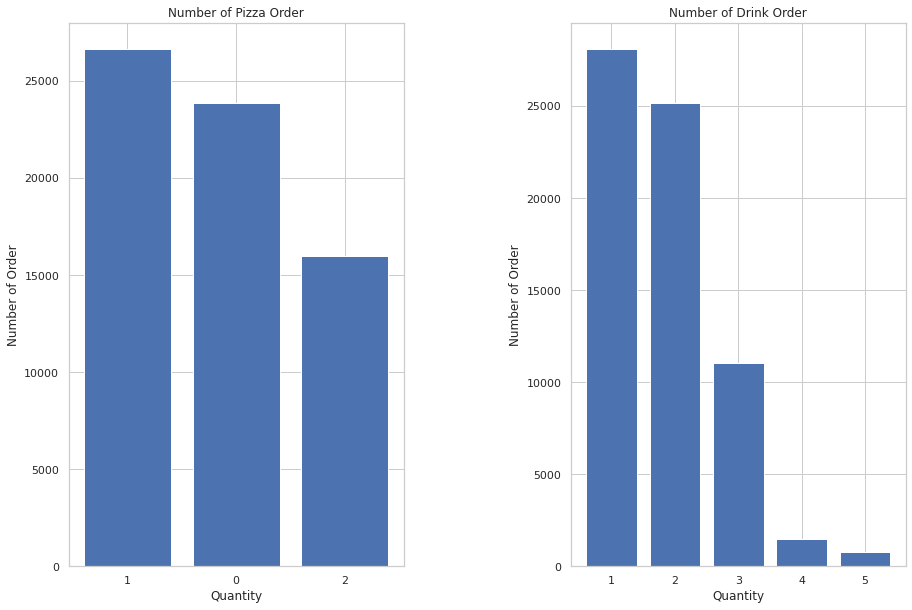

In [59]:
# Cluster 0

# plot
plt.figure(1, figsize=(15,10))
sns.set_theme(style="whitegrid")

plates_name, cluster = ['pizza','drink'], 0
for p in range(1,3):   
    
    # plot data
    plt.subplot(1, 2, p)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.bar(values_table_all[cluster][p].index.astype(str), values_table_all[cluster][p])
    plt.title(f'Number of {plates_name[p-1].capitalize()} Order')
    plt.xlabel('Quantity')
    plt.ylabel('Number of Order')

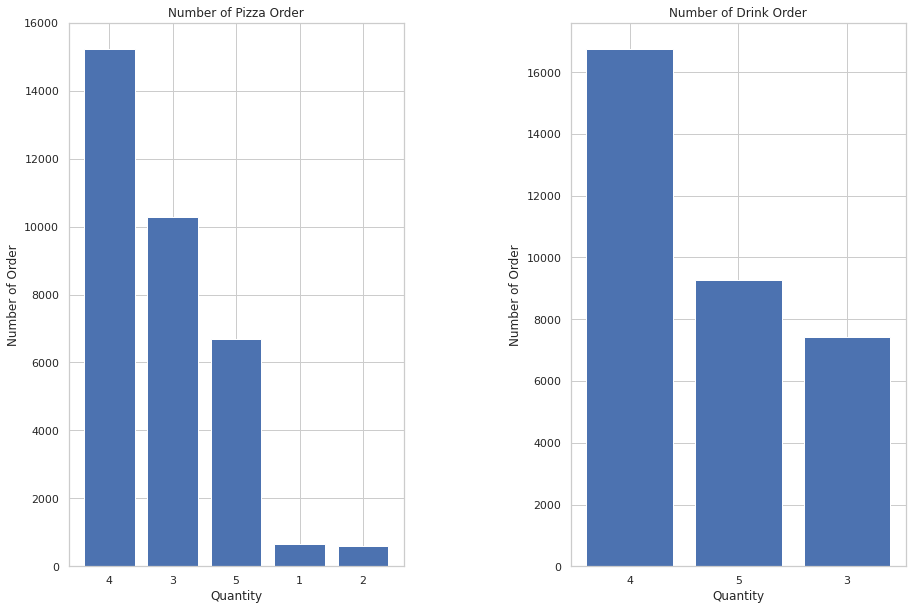

In [60]:
# Cluster 1

# plot
plt.figure(1, figsize=(15,10))
sns.set_theme(style="whitegrid")

plates_name, cluster = ['pizza','drink'], 1
for p in range(1,3):   
    
    # plot data
    plt.subplot(1, 2, p)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.bar(values_table_all[cluster][p].index.astype(str), values_table_all[cluster][p])
    plt.title(f'Number of {plates_name[p-1].capitalize()} Order')
    plt.xlabel('Quantity')
    plt.ylabel('Number of Order')

## Segmentation using Pizza, Desert, Drink and Salad with 5 cluster

### Model Creation

In [20]:
model = KMeans(n_clusters=5, init='k-means++', 
               n_init=10, max_iter=300, 
               tol=0.0001, random_state=111, 
               algorithm = 'elkan')
model.fit(X2)
X2_df['labels'] = model.labels_
X2_df.head(3)

/home/salomao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_order,pizza,desert,drink,salad,labels
0,0x10000a,1,1,0,0,0
1,0x100058,2,2,0,0,3
2,0x1000c8,4,5,4,1,4


### Analyzing the Created Segments

In [39]:
values_table_all, index_tuples, rows = [], [], []
    
for i in X2_df.labels.unique():
    
    df_tmp = X2_df[X2_df['labels'] == i]
    mean = ['Mean']
    summation = ['Summation']
    median = ['Median']
    mode = ['Mode']
    maxi = ['Max']
    mini = ['Min']
    values_table = [i]
    
    for p in range(1,5):
        mean.append(np.round(df_tmp.iloc[:,p].mean(),3))
        summation.append(df_tmp.iloc[:,p].sum())
        median.append(np.round(df_tmp.iloc[:,p].median(),3))
        mode.append(df_tmp.iloc[:,p].mode()[0])
        maxi.append(df_tmp.iloc[:,p].max())
        mini.append(df_tmp.iloc[:,p].min())
        values_table.append(df_tmp.iloc[:,p].value_counts())
    for _ in range(6):
        index_tuples.append((i,np.round(model.inertia_,3)))
    rows.append(mean)
    rows.append(summation)
    rows.append(median)
    rows.append(mode)
    rows.append(maxi)
    rows.append(mini)
    values_table_all.append(values_table)

df_final = pd.DataFrame(data=rows, columns=['metrics','pizza','desert','drink','salad'], 
                        index=pd.MultiIndex.from_tuples(index_tuples, names=["cluster", "WCSS"]))
df_final

metrics      pizza     desert      drink      salad
cluster WCSS                                                             
0       124626.318       Mean      0.721      1.105      0.194      0.384
        124626.318  Summation  22665.000  34742.000   6098.000  12077.000
        124626.318     Median      1.000      1.000      0.000      0.000
        124626.318       Mode      1.000      1.000      0.000      0.000
        124626.318        Max      1.000      2.000      1.000      1.000
        124626.318        Min      0.000      1.000      0.000      0.000
3       124626.318       Mean      2.163      2.255      0.700      0.092
        124626.318  Summation  39612.000  41301.000  12818.000   1689.000
        124626.318     Median      2.000      2.000      0.000      0.000
        124626.318       Mode      2.000      2.000      0.000      0.000
        124626.318        Max      4.000      4.000      2.000      1.000
        124626.318        Min      2.000      2.000      0.000      0.000
4       124626.318       Mean      4.819      5.000      4.591      0.181
        124626.318  Summation  30469.000  31615.000  29030.000   1146.000
        124626.318     Median      5.000      5.000      5.000      0.000
        124626.318       Mode      5.000      5.000      5.000      0.000
        124626.318        Max      5.000      5.000      5.000      1.000
        124626.318        Min      4.000      5.000      3.000      0.000
1       124626.318       Mean      3.685      3.838      3.122      0.153
        124626.318  Summation  87568.000  91213.000  74201.000   3645.000
        124626.318     Median      4.000      4.000      3.000      0.000
        124626.318       Mode      4.000      4.000      4.000      0.000
        124626.318        Max      5.000      5.000      4.000      2.000
        124626.318        Min      2.000      3.000      0.000      0.000
2       124626.318       Mean      0.271      2.878      0.090      2.607
        124626.318  Summation   5470.000  58050.000   1812.000  52580.000
        124626.318     Median      0.000      3.000      0.000      2.000
        124626.318       Mode      0.000      3.000      0.000      2.000
        124626.318        Max      3.000      5.000      2.000      5.000
        124626.318        Min      0.000      2.000      0.000      2.000

### Plot number of order in each cluster

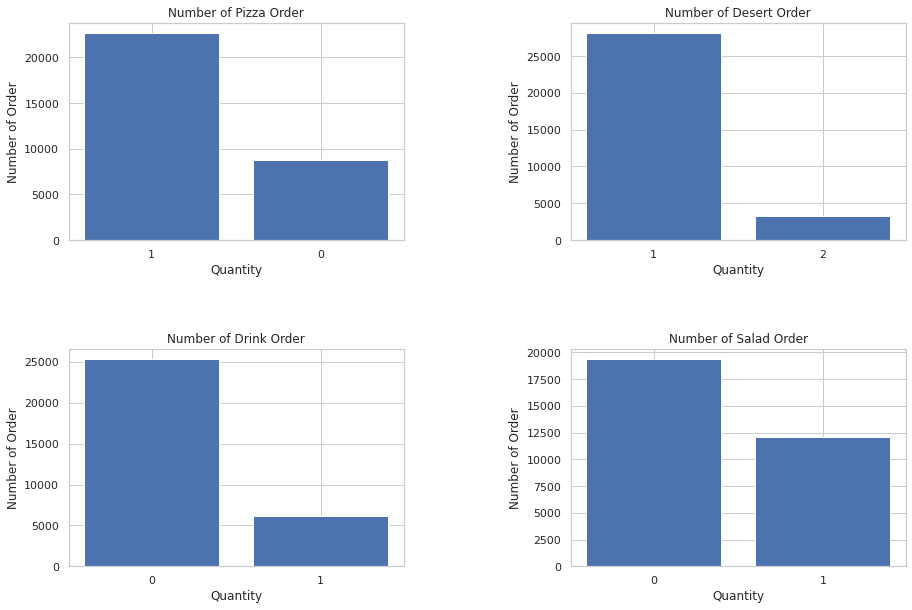

In [40]:
# Cluster 0

# plot
plt.figure(1, figsize=(15,10))
sns.set_theme(style="whitegrid")

plates_name, cluster = ['pizza','desert','drink','salad'], 0
for p in range(1,5):   
    
    # plot data
    plt.subplot(2, 2, p)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.bar(values_table_all[cluster][p].index.astype(str), values_table_all[cluster][p])
    plt.title(f'Number of {plates_name[p-1].capitalize()} Order')
    plt.xlabel('Quantity')
    plt.ylabel('Number of Order')

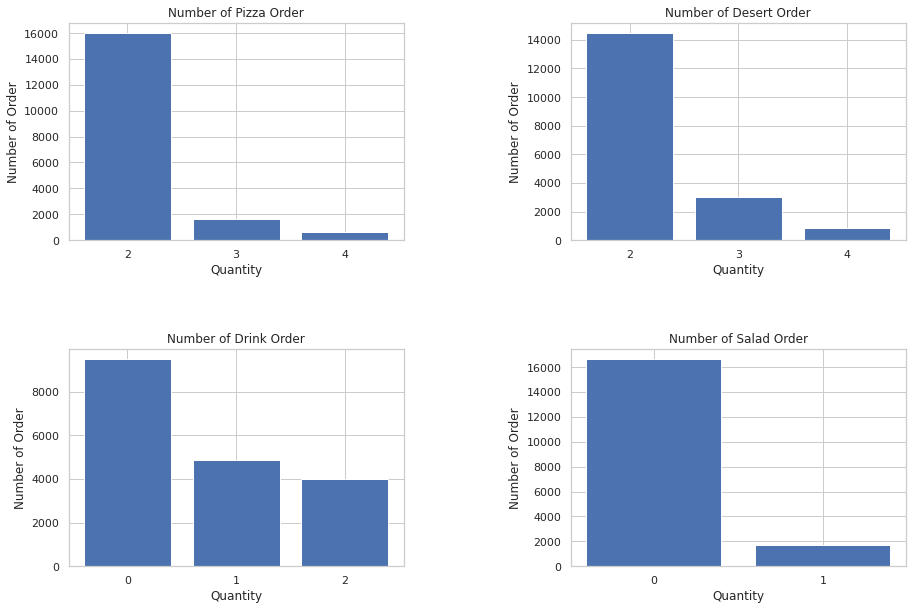

In [41]:
# Cluster 1

# plot
plt.figure(1, figsize=(15,10))
sns.set_theme(style="whitegrid")

plates_name, cluster = ['pizza','desert','drink','salad'], 1
for p in range(1,5):   
    
    # plot data
    plt.subplot(2, 2, p)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.bar(values_table_all[cluster][p].index.astype(str), values_table_all[cluster][p])
    plt.title(f'Number of {plates_name[p-1].capitalize()} Order')
    plt.xlabel('Quantity')
    plt.ylabel('Number of Order')

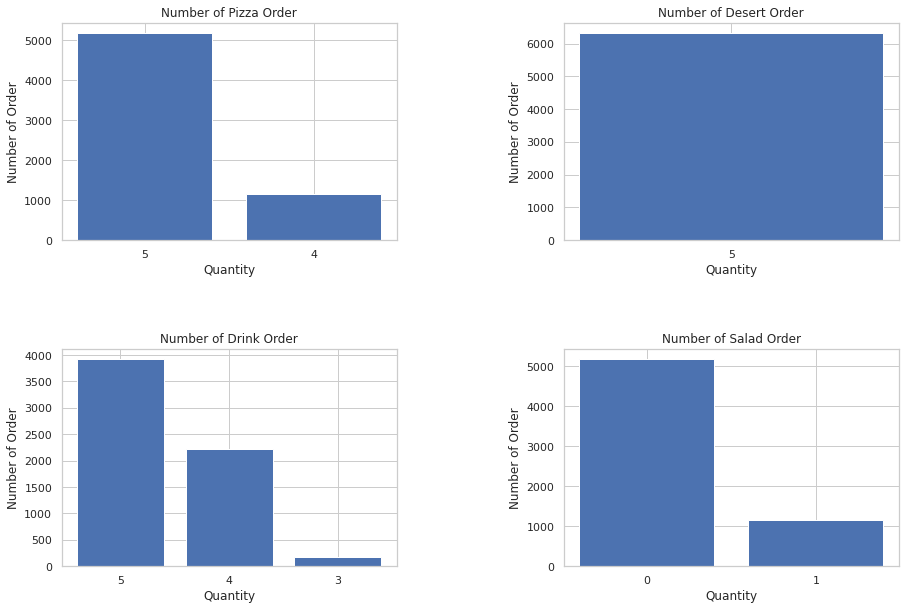

In [42]:
# Cluster 2

# plot
plt.figure(1, figsize=(15,10))
sns.set_theme(style="whitegrid")

plates_name, cluster = ['pizza','desert','drink','salad'], 2
for p in range(1,5):   
    
    # plot data
    plt.subplot(2, 2, p)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.bar(values_table_all[cluster][p].index.astype(str), values_table_all[cluster][p])
    plt.title(f'Number of {plates_name[p-1].capitalize()} Order')
    plt.xlabel('Quantity')
    plt.ylabel('Number of Order')

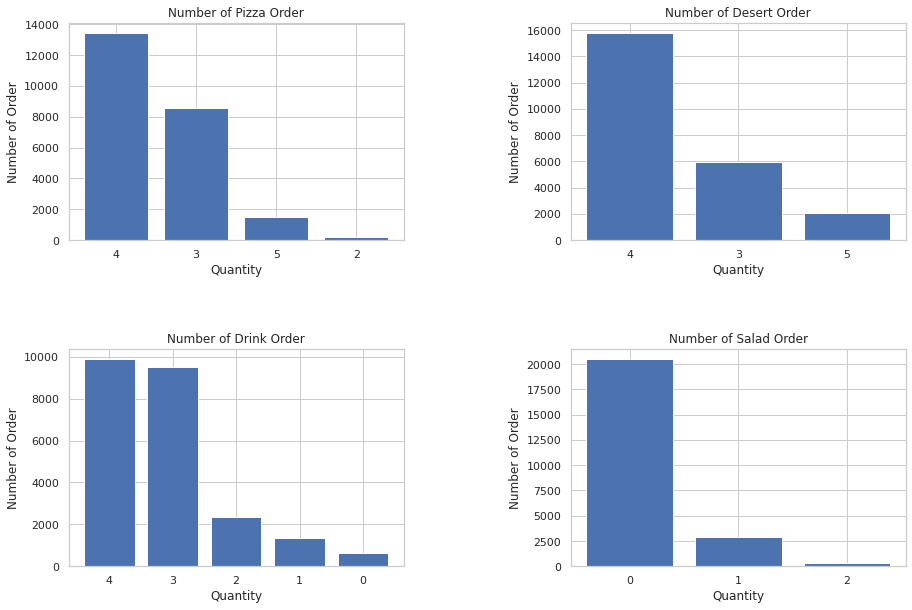

In [43]:
# Cluster 3

# plot
plt.figure(1, figsize=(15,10))
sns.set_theme(style="whitegrid")

plates_name, cluster = ['pizza','desert','drink','salad'], 3
for p in range(1,5):   
    
    # plot data
    plt.subplot(2, 2, p)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.bar(values_table_all[cluster][p].index.astype(str), values_table_all[cluster][p])
    plt.title(f'Number of {plates_name[p-1].capitalize()} Order')
    plt.xlabel('Quantity')
    plt.ylabel('Number of Order')

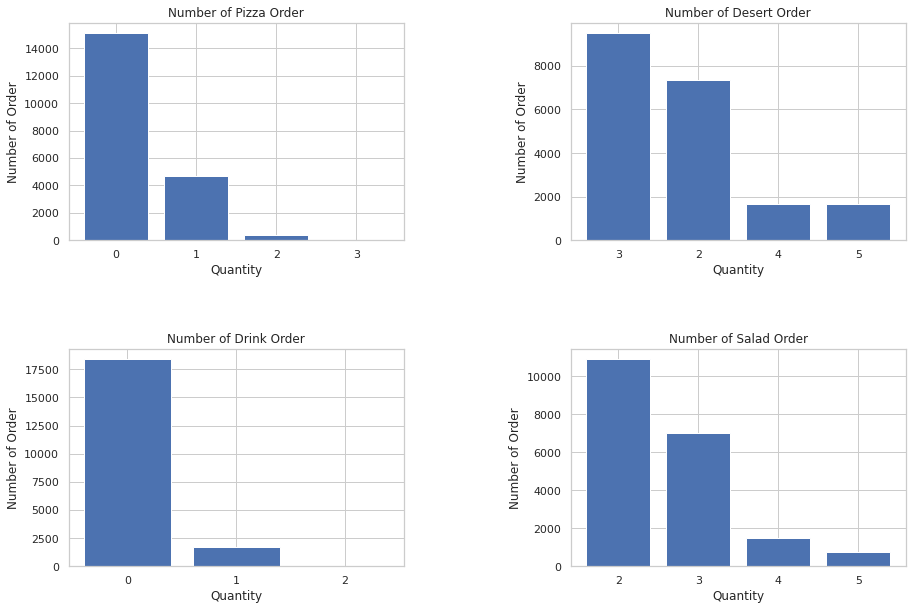

In [44]:
# Cluster 4

# plot
plt.figure(1, figsize=(15,10))
sns.set_theme(style="whitegrid")

plates_name, cluster = ['pizza','desert','drink','salad'], 4
for p in range(1,5):   
    
    # plot data
    plt.subplot(2, 2, p)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.bar(values_table_all[cluster][p].index.astype(str), values_table_all[cluster][p])
    plt.title(f'Number of {plates_name[p-1].capitalize()} Order')
    plt.xlabel('Quantity')
    plt.ylabel('Number of Order')